### AlexNet代码实现

In [1]:
# 导入必要的库，torchinfo用于查看模型结构
import torch
import torch.nn as nn
from torchinfo import summary

### 结构定义

In [2]:
# 定义AlexNet的网络结构
class AlexNet(nn.Module):
    def __init__(self, num_classes=1000, dropout=0.5):
        super().__init__()
        # 定义卷积层
        self.features = nn.Sequential(
            # 卷积+ReLU+最大池化
            # 原始论文是在2个GPU上训练(每个48通道),后续都是单GPU/CPU训练,简化为64通道
            # 这一调整既能保持模型的基本结构，又能减少约 30% 的参数量，提高训练效率
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            # inplace=False:默认值,经过Relu是生成一个新的变量,True:直接原地修改输入
            # 可以节省内存占用,但是需要注意原始输入没有依赖才可以使用
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            # 卷积+ReLU+最大池化
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            # 卷积+ReLU
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            # 卷积+ReLU
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            # 卷积+ReLU
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            # 最大池化
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        # 自适应平均池化 : 它指定的是输出特征图的尺寸，而非池化窗口的大小或步长
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        # 定义全连接层
        self.classifier = nn.Sequential(
            # Dropout+全连接层+ReLU
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            # Dropout+全连接层+ReLU
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            # 全连接层
            nn.Linear(4096, num_classes),
        )

    # 定义前向传播函数
    def forward(self, x):
        x = self.features(x)        # 提取特征
        x = self.avgpool(x)         # 平均池化
        x = torch.flatten(x, 1)     # 转换为1维张量
        x = self.classifier(x)      # 使用全连接层训练
        return x

### 网络结构

In [3]:
# 查看模型结构及参数量，input_size表示示例输入数据的维度信息
summary(AlexNet(), input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
AlexNet                                  [1, 1000]                 --
├─Sequential: 1-1                        [1, 256, 6, 6]            --
│    └─Conv2d: 2-1                       [1, 64, 55, 55]           23,296
│    └─ReLU: 2-2                         [1, 64, 55, 55]           --
│    └─MaxPool2d: 2-3                    [1, 64, 27, 27]           --
│    └─Conv2d: 2-4                       [1, 192, 27, 27]          307,392
│    └─ReLU: 2-5                         [1, 192, 27, 27]          --
│    └─MaxPool2d: 2-6                    [1, 192, 13, 13]          --
│    └─Conv2d: 2-7                       [1, 384, 13, 13]          663,936
│    └─ReLU: 2-8                         [1, 384, 13, 13]          --
│    └─Conv2d: 2-9                       [1, 256, 13, 13]          884,992
│    └─ReLU: 2-10                        [1, 256, 13, 13]          --
│    └─Conv2d: 2-11                      [1, 256, 13, 13]         

### torchvision

In [4]:
# 查看torchvision自带的模型结构及参数量
from torchvision import models
summary(models.alexnet(), input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
AlexNet                                  [1, 1000]                 --
├─Sequential: 1-1                        [1, 256, 6, 6]            --
│    └─Conv2d: 2-1                       [1, 64, 55, 55]           23,296
│    └─ReLU: 2-2                         [1, 64, 55, 55]           --
│    └─MaxPool2d: 2-3                    [1, 64, 27, 27]           --
│    └─Conv2d: 2-4                       [1, 192, 27, 27]          307,392
│    └─ReLU: 2-5                         [1, 192, 27, 27]          --
│    └─MaxPool2d: 2-6                    [1, 192, 13, 13]          --
│    └─Conv2d: 2-7                       [1, 384, 13, 13]          663,936
│    └─ReLU: 2-8                         [1, 384, 13, 13]          --
│    └─Conv2d: 2-9                       [1, 256, 13, 13]          884,992
│    └─ReLU: 2-10                        [1, 256, 13, 13]          --
│    └─Conv2d: 2-11                      [1, 256, 13, 13]         

### mac GPU加速配置

In [5]:
import torch
# 首先确认您的 PyTorch 版本是否支持 Metal 后端（Apple GPU 加速）
print(torch.version.__version__)  # 应显示2.0.0或更高
print(torch.backends.mps.is_available())  # 应显示True
print(torch.backends.mps.is_built())     # 应显示True

# 设备配置 - 启用AMD Radeon GPU加速
# 设置设备，优先使用GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"使用训练设备: {device}")

2.2.2
True
True
使用训练设备: mps


### 模型训练

模型主设备: mps:0

检查所有模型参数的设备:
损失函数设备: N/A
优化器参数设备: mps:0


  0%|          | 0/50 [00:00<?, ?it/s]

train epoch 1/50:   0%|          | 0/97 [00:00<?, ?it/s]

test  epoch 1/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 1   Loss: 2.6486   Accuracy: 0.0098  


train epoch 2/50:   0%|          | 0/97 [00:00<?, ?it/s]

test  epoch 2/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 2   Loss: 2.6596   Accuracy: 0.0098  


train epoch 3/50:   0%|          | 0/97 [00:00<?, ?it/s]

test  epoch 3/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 3   Loss: 3.0175   Accuracy: 0.0098  


train epoch 4/50:   0%|          | 0/97 [00:00<?, ?it/s]

test  epoch 4/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 4   Loss: 3.5871   Accuracy: 0.0098  


train epoch 5/50:   0%|          | 0/97 [00:00<?, ?it/s]

test  epoch 5/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 5   Loss: 3.9198   Accuracy: 0.0098  


train epoch 6/50:   0%|          | 0/97 [00:00<?, ?it/s]

test  epoch 6/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 6   Loss: 4.0087   Accuracy: 0.0098  


train epoch 7/50:   0%|          | 0/97 [00:00<?, ?it/s]

test  epoch 7/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 7   Loss: 4.0116   Accuracy: 0.0098  


train epoch 8/50:   0%|          | 0/97 [00:00<?, ?it/s]

test  epoch 8/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 8   Loss: 3.6610   Accuracy: 0.0098  


train epoch 9/50:   0%|          | 0/97 [00:00<?, ?it/s]

test  epoch 9/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 9   Loss: 3.2968   Accuracy: 0.0098  


train epoch 10/50:   0%|          | 0/97 [00:00<?, ?it/s]

test  epoch 10/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 10  Loss: 3.2112   Accuracy: 0.0098  


train epoch 11/50:   0%|          | 0/97 [00:00<?, ?it/s]

test  epoch 11/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 11  Loss: 3.3573   Accuracy: 0.0098  


train epoch 12/50:   0%|          | 0/97 [00:00<?, ?it/s]

test  epoch 12/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 12  Loss: 3.6018   Accuracy: 0.0098  


train epoch 13/50:   0%|          | 0/97 [00:00<?, ?it/s]

test  epoch 13/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 13  Loss: 3.8776   Accuracy: 0.0098  


train epoch 14/50:   0%|          | 0/97 [00:00<?, ?it/s]

test  epoch 14/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 14  Loss: 3.3754   Accuracy: 0.0098  


train epoch 15/50:   0%|          | 0/97 [00:00<?, ?it/s]

test  epoch 15/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 15  Loss: 3.1971   Accuracy: 0.0098  


train epoch 16/50:   0%|          | 0/97 [00:00<?, ?it/s]

test  epoch 16/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 16  Loss: 2.7894   Accuracy: 0.0098  


train epoch 17/50:   0%|          | 0/97 [00:00<?, ?it/s]

test  epoch 17/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 17  Loss: 3.0284   Accuracy: 0.0098  


train epoch 18/50:   0%|          | 0/97 [00:00<?, ?it/s]

test  epoch 18/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 18  Loss: 3.3715   Accuracy: 0.0098  


train epoch 19/50:   0%|          | 0/97 [00:00<?, ?it/s]

test  epoch 19/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 19  Loss: 4.0080   Accuracy: 0.0069  


train epoch 20/50:   0%|          | 0/97 [00:00<?, ?it/s]

test  epoch 20/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 20  Loss: 3.7636   Accuracy: 0.0098  


train epoch 21/50:   0%|          | 0/97 [00:00<?, ?it/s]

test  epoch 21/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 21  Loss: 3.7717   Accuracy: 0.0108  


train epoch 22/50:   0%|          | 0/97 [00:00<?, ?it/s]

test  epoch 22/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 22  Loss: 3.8847   Accuracy: 0.0098  


train epoch 23/50:   0%|          | 0/97 [00:00<?, ?it/s]

test  epoch 23/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 23  Loss: 3.6412   Accuracy: 0.0098  


train epoch 24/50:   0%|          | 0/97 [00:00<?, ?it/s]

test  epoch 24/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 24  Loss: 2.6318   Accuracy: 0.0098  


train epoch 25/50:   0%|          | 0/97 [00:00<?, ?it/s]

test  epoch 25/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 25  Loss: 2.6320   Accuracy: 0.0098  


train epoch 26/50:   0%|          | 0/97 [00:00<?, ?it/s]

test  epoch 26/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 26  Loss: 2.6309   Accuracy: 0.0098  


train epoch 27/50:   0%|          | 0/97 [00:00<?, ?it/s]

test  epoch 27/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 27  Loss: 2.6317   Accuracy: 0.0098  


train epoch 28/50:   0%|          | 0/97 [00:00<?, ?it/s]

test  epoch 28/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 28  Loss: 2.6313   Accuracy: 0.0098  


train epoch 29/50:   0%|          | 0/97 [00:00<?, ?it/s]

test  epoch 29/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 29  Loss: 2.6312   Accuracy: 0.0098  


train epoch 30/50:   0%|          | 0/97 [00:00<?, ?it/s]

test  epoch 30/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 30  Loss: 2.6314   Accuracy: 0.0098  


train epoch 31/50:   0%|          | 0/97 [00:00<?, ?it/s]

test  epoch 31/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 31  Loss: 2.6316   Accuracy: 0.0098  


train epoch 32/50:   0%|          | 0/97 [00:00<?, ?it/s]

test  epoch 32/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 32  Loss: 2.6315   Accuracy: 0.0098  


train epoch 33/50:   0%|          | 0/97 [00:00<?, ?it/s]

test  epoch 33/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 33  Loss: 2.6307   Accuracy: 0.0098  


train epoch 34/50:   0%|          | 0/97 [00:00<?, ?it/s]

test  epoch 34/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 34  Loss: 2.6312   Accuracy: 0.0098  


train epoch 35/50:   0%|          | 0/97 [00:00<?, ?it/s]

test  epoch 35/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 35  Loss: 2.6309   Accuracy: 0.0098  


train epoch 36/50:   0%|          | 0/97 [00:00<?, ?it/s]

test  epoch 36/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 36  Loss: 2.6308   Accuracy: 0.0098  


train epoch 37/50:   0%|          | 0/97 [00:00<?, ?it/s]

test  epoch 37/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 37  Loss: 2.6311   Accuracy: 0.0098  


train epoch 38/50:   0%|          | 0/97 [00:00<?, ?it/s]

test  epoch 38/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 38  Loss: 2.6307   Accuracy: 0.0098  


train epoch 39/50:   0%|          | 0/97 [00:00<?, ?it/s]

test  epoch 39/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 39  Loss: 2.6310   Accuracy: 0.0098  


train epoch 40/50:   0%|          | 0/97 [00:00<?, ?it/s]

test  epoch 40/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 40  Loss: 2.6309   Accuracy: 0.0098  


train epoch 41/50:   0%|          | 0/97 [00:00<?, ?it/s]

test  epoch 41/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 41  Loss: 2.6312   Accuracy: 0.0098  


train epoch 42/50:   0%|          | 0/97 [00:00<?, ?it/s]

test  epoch 42/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 42  Loss: 2.6305   Accuracy: 0.0098  


train epoch 43/50:   0%|          | 0/97 [00:00<?, ?it/s]

test  epoch 43/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 43  Loss: 2.6305   Accuracy: 0.0098  


train epoch 44/50:   0%|          | 0/97 [00:00<?, ?it/s]

test  epoch 44/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 44  Loss: 2.6315   Accuracy: 0.0098  


train epoch 45/50:   0%|          | 0/97 [00:00<?, ?it/s]

test  epoch 45/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 45  Loss: 2.6306   Accuracy: 0.0098  


train epoch 46/50:   0%|          | 0/97 [00:00<?, ?it/s]

test  epoch 46/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 46  Loss: 2.6313   Accuracy: 0.0098  


train epoch 47/50:   0%|          | 0/97 [00:00<?, ?it/s]

test  epoch 47/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 47  Loss: 2.6313   Accuracy: 0.0098  


train epoch 48/50:   0%|          | 0/97 [00:00<?, ?it/s]

test  epoch 48/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 48  Loss: 2.6307   Accuracy: 0.0098  


train epoch 49/50:   0%|          | 0/97 [00:00<?, ?it/s]

test  epoch 49/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 49  Loss: 2.6310   Accuracy: 0.0098  


train epoch 50/50:   0%|          | 0/97 [00:00<?, ?it/s]

test  epoch 50/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 50  Loss: 2.6311   Accuracy: 0.0098  


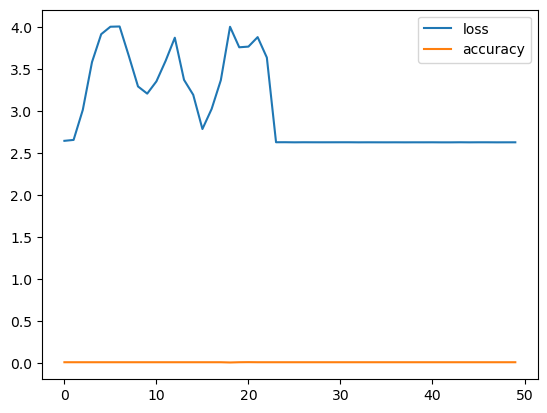

Final Accuracy: 0.00980392156862745


In [ ]:
# 导入必要的库
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from tqdm.notebook import tqdm
import numpy as np
import sys,os
from torch.optim import lr_scheduler

# 设置随机种子
torch.manual_seed(0)
batch_size = 64
num_workers = 8  # 8个工作线程

# 设置训练集的数据变换，进行数据增强(会生成新的图像,来丰富数据)
trainform_train = transforms.Compose([
    transforms.RandomRotation(30),              # 随机旋转 -30度到30度之间
    
    # 随机裁剪图像的一部分区域，然后将其调整为指定大小（224×224 像素）。
    # 裁剪区域的大小和宽高比是随机的（默认范围：裁剪面积为原图的 0.08~1.0 倍，裁剪宽高比为 3/4~4/3）
    # transforms.RandomResizedCrop((224, 224)),   # 随机比例裁剪并进行resize
    
    # 在原图中随机选择一个 224×224 的区域（不改变宽高比）。
    transforms.RandomCrop(224),  # 比RandomResizedCrop计算量小

    transforms.RandomHorizontalFlip(p = 0.5),   # 随机水平翻转
    transforms.RandomVerticalFlip(p = 0.5),     # 随机垂直翻转
    transforms.ToTensor(),                      # 将数据转换为张量,并归一化到[0,1]区间
    # 对三通道数据进行归一化(均值，标准差)，数值是从ImageNet数据集上的百万张图片中随机抽样计算得到
    # 这些值被广泛用于预训练模型（如 ResNet、VGG、AlexNet 等）的输入预处理。
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 设置测试集的数据变换，不进行数据增强，仅使用resize和归一化
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),  # 将图像的短边调整为指定长度（224 像素），长边按原始比例缩放
    transforms.ToTensor(),  # 将数据转换为张量
    # 对三通道数据进行归一化(均值，标准差)，数值是从ImageNet数据集上的百万张图片中随机抽样计算得到
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 加载训练数据，需要特别注意的是Flowers102数据集，test簇的数据量较多些，可以选择使用"test"作为训练集(本地太慢,还是用原始分类)
# https://www.robots.ox.ac.uk/~vgg/data/flowers/102/categories.html
train_dataset = datasets.Flowers102(root='../data/flowers102', split="test", download=True, transform=trainform_train)
# 加载测试数据，使用"test"作为测试集
test_dataset = datasets.Flowers102(root='../data/flowers102', split="train", download=True, transform=transform_test)

# 实例化训练数据加载器
# num_workers参数指定了用于数据加载的子进程数量来加速数据加载
# GPU模式启用pin_memory
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,num_workers=num_workers,pin_memory=True,persistent_workers=True)
# 实例化测试数据加载器
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,num_workers=num_workers,pin_memory=True,persistent_workers=True)

# 定义模型、优化器、损失函数
# 使用预训练模型 - 简化架构适合CPU
from torchvision.models import AlexNet_Weights
# weights=AlexNet_Weights.IMAGENET1K_V1 等同于旧版的 pretrained=True，使用在 ImageNet 上预训练的权重
# 如果你想要使用最新的预训练权重，可以用 weights=AlexNet_Weights.DEFAULT
# model = models.alexnet(weights=AlexNet_Weights.DEFAULT)
# 冻结大部分预训练层，只训练最后几层
# for param in list(model.parameters())[:-4]:
#     param.requires_grad = False
# 修改分类器适应Flower102
# 简化分类器结构
# num_ftrs = model.classifier[6].in_features
# model.classifier[6] = nn.Linear(num_ftrs, 102)
model = AlexNet(num_classes=102).to(device)
model = model.to(device)


# 优化器 - 使用针对GPU优化的AdamW
optimizer = optim.AdamW(
    model.parameters(), 
    lr=0.001,  # AdamW通常使用较低的学习率
    weight_decay=1e-4
)

# 设置epoch数并开始训练
num_epochs = 50  # 设置epoch数

criterion = nn.CrossEntropyLoss().to(device)

loss_history = []  # 创建损失历史记录列表
acc_history = []   # 创建准确率历史记录列表


# 检查模型设备
print(f"模型主设备: {next(model.parameters()).device}")
# 递归检查所有参数
print("\n检查所有模型参数的设备:")
for name, param in model.named_parameters():
    if param.device.type != 'mps':
        print(f"警告: 参数 {name} 在 {param.device} 而非 MPS 设备上!")
# 检查损失函数设备
print(f"损失函数设备: {criterion.device if hasattr(criterion, 'device') else 'N/A'}")
# 检查优化器
print(f"优化器参数设备: {optimizer.param_groups[0]['params'][0].device}")


# 检查数据加载器
# print("\n检查数据加载器输出的设备:")
# inputs, labels = next(iter(dataloaders['train']))
# print(f"输入数据设备: {inputs.device}")
# print(f"标签设备: {labels.device}")


# tqdm用于显示进度条并评估任务时间开销
for epoch in tqdm(range(num_epochs)):
    # 记录损失和预测正确数
    total_loss = 0
    total_correct = 0
    
    # 批量训练
    model.train()
    progress_bar = tqdm(train_loader, total=len(train_loader), desc=f'train epoch {epoch+1}/{num_epochs}')
    for inputs, labels in progress_bar:
        # 将数据转移到指定计算资源设备上
        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        # 预测、损失函数、反向传播
        optimizer.zero_grad(set_to_none=True)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # scheduler.step()
        # 记录训练集loss
        total_loss += loss.item()
        progress_bar.set_postfix({'loss': f'{np.log10(loss.item()):.4f}','lr':f'{optimizer.param_groups[0]['lr']:.4f}'})
        
    
    # 测试模型，不计算梯度
    model.eval()
    with torch.no_grad():
        # progress_bar = tqdm(enumerate(test_loader), total=len(test_loader), desc=f'test epoch {epoch+1}/{num_epochs}')
        progress_bar = tqdm(test_loader, total=len(test_loader), desc=f'test  epoch {epoch+1}/{num_epochs}')
        for inputs, labels in progress_bar:
            # 将数据转移到指定计算资源设备上
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # 预测
            outputs = model(inputs)
            # 记录测试集预测正确数
            total_correct += (outputs.argmax(1) == labels).sum().item()
            # progress_bar.set_postfix({'acc': f'{100 * correct / total:.2f}%'})

        
    # 记录训练集损失和测试集准确率
    loss_history.append(np.log10(total_loss))  # 将损失加入损失历史记录列表，由于数值有时较大，这里取对数
    acc_history.append(total_correct / len(test_dataset))# 将准确率加入准确率历史记录列表
    
    # 打印中间值
    tqdm.write(f"Epoch: {epoch+1:<3} Loss: {loss_history[-1]:<8.4f} Accuracy: {acc_history[-1]:<8.4f}")

# 使用Matplotlib绘制损失和准确率的曲线图
import matplotlib.pyplot as plt
plt.plot(loss_history, label='loss')
plt.plot(acc_history, label='accuracy')
plt.legend()
plt.show()

# 输出准确率
print("Final Accuracy:", acc_history[-1])